In [43]:
!pip install efficientnet
!pip install nnAudio

In [47]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2979 sha256=219484b3f4bd8b080845309c741c93d16f665f231eba6d5a0186d32ee5f81c78
  Stored in directory: c:\users\dheer\appdata\local\pip\cache\wheels\06\7e\ad\1cb03e935234186825cefc7e2c8f3451b4f654b5bc72232a7b
Successfully built import-ipynb


In [3]:
import import_ipynb

In [54]:

import pandas as pd
import math
import numpy as np

from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential, utils, optimizers, metrics
import tensorflow as tf
import tensorflow.keras.layers as layers

from matplotlib import pyplot as plt,mlab as mlb

from sklearn.model_selection import train_test_split

from random import shuffle
from nnAudio.Spectrogram import CQT1992v2
import torch


from efficientnet.tfkeras import EfficientNetB0, EfficientNetB1

from scipy import signal, fft
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

import os
import time
import seaborn as sns
from copy import copy,deepcopy

import readligo as rl

ModuleNotFoundError: No module named 'readligo'

In [55]:
inp_dir=r'C:\Users\dheer\Downloads\g2net-gravitational-wave-detection'
s_freq=2048
s_time=2

In [56]:
class DataPreprocessing:
    def __init__(self,inp_dir):
        self.inp_d=inp_dir
        
    def np_array(self,i,train=True):
        ch_0,ch_1,ch_2=i[0],i[1],i[2]
        if train:
            fp=f"{inp_dir}/train/{ch_0}/{ch_1}/{ch_2}/{i}.npy"
        else:
            fp=f"{inp_dir}/test/{ch_0}/{ch_1}/{ch_2}/{i}.npy"
        return np.load(fp)
    
    targets=pd.read_csv(f"{inp_dir}/training_labels.csv")
    y=targets["target"].values
    all_identifiers = targets["id"].values
    id_1=targets[targets["target"] == 1]["id"].values
    id_0=targets[targets["target"] == 0]["id"].values
    
    def np_array_normalized(self,i,train=True):
        x=self.np_array(i,train)
        x_n=[0]*len(x)
        x_n[0]=x[0]/np.max(x[0])
        x_n[1]=x[1]/np.max(x[1])
        x_n[2]=x[2]/np.max(x[2])
        return x_n
    
    def GW_np(self,i,train=True):
        x={q:w for q,w in zip(['L','H','V'],self.np_array(i,train))}
        x_n={q:w for q,w in zip(['L','H','V'],self.np_array_normalized(i,train))}
        return {'a':x,'a_n':x_n}
    def cqt_spectrogram(self,i,train=True):
        cqt = CQT1992v2(sr=s_freq,hop_length=64, fmin=20, fmax=1024, bins_per_octave=12, norm=1, window='hann', center=True, pad_mode='reflect', trainable=False, output_format='Magnitude', verbose=False)
        waveform=np.hstack(self.np_array(i,train))
        waveform=waveform/np.max(waveform)
        waveform=torch.from_numpy(waveform).float()
        cqt_image=cqt(waveform)
        cqt_image=np.array(cqt_image)
        cqt_image=np.transpose(cqt_image, (1,2,0))
        return cqt_image
    def spectrogram(self,i,train=True):
        waveform=np.hstack(self.np_array(i,train))
        waveform=waveform/np.max(waveform)
        (freq,time,intensity)=signal.spectrogram(waveform,s_freq, mode="magnitude", scaling="spectrum", window=('kaiser', 14))
        return (freq,time,intensity)

In [57]:
class DataVisualization(DataPreprocessing):
    def __init__(self,inp_dir):
        DataPreprocessing.__init__(self,inp_dir)
    def plot(self,i,l,n=False,train=True):
        x=self.GW_np(i)['a_n'][l] if n else self.GW_np(i)['a'][l]
        plt.figure(figsize=(20,5))
        plt.plot(x)
        plt.xlabel("sample")
        plt.ylabel(l+" strain") if not n else plt.ylabel(l+"n_strain")
        plt.title(f"timeseries plot of data {i} - {self.targets[self.targets['id']==i].target.values}")
    def plot_hstack(self,i,n=False,train=True):
        x=self.GW_np(i)['a'] if n==False else self.GW_np(i)['a_n']
        x=[*x.values()]
        plt.figure(figsize=(20,5))
        plt.plot(np.hstack(x))
        plt.xlabel("sample")
        plt.ylabel("n_strain") if n else plt.ylabel("strain")
        plt.title(f"hstack of data {i} - {self.targets[self.targets['id']==i].target.values}")
    def plot_parallel(self,i,n=False,train=True):
        x=x=self.GW_np(i)['a'] if n==False else self.GW_np(i)['a_n']
        plt.figure(figsize=(20,5))
        plt.plot(x['L'], color="red", label="L")
        plt.plot(x['H'], color="green", label="H")
        plt.plot(x['V'], color="blue", label="V")
        plt.xlabel("sample")
        plt.ylabel("n_strain") if n else plt.ylabel("strain")
        plt.legend()
        plt.title(f"timeseries plot of data {i} - {self.targets[self.targets['id']==i].target.values}")
        
    def plot_cqt_spectrogram(self,i,train=True):
        image=self.cqt_spectrogram(i,train)
        plt.figure(figsize=(20,5))
        plt.imshow(image)
        plt.xlabel("scaled time")
        plt.ylabel("scaled frequency")
        plt.legend()
        plt.title(f"CQT1992 (nnAudio) spectrogram of hstack'd data {i} - {self.targets[self.targets['id']==i].target.values}")
    
    def plot_spectrogram(i,train=True):
        (f,t,i)=spectrogram(i,train)
        plt.figure(figsize=(20,5))
        plt.pcolormesh(t,f,i,shading='gouraud')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.ylim(0,100)
        plt.title(f"Scipy spectrogram of hstack'd data {i} - {self.targets[self.targets['id']==i].target.values}")

x=DataVisualization(inp_dir)

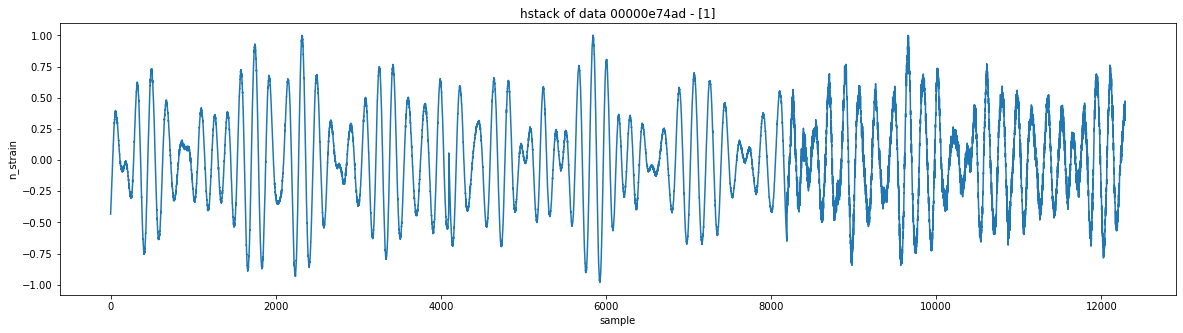

In [58]:
x.plot_hstack('00000e74ad',True)

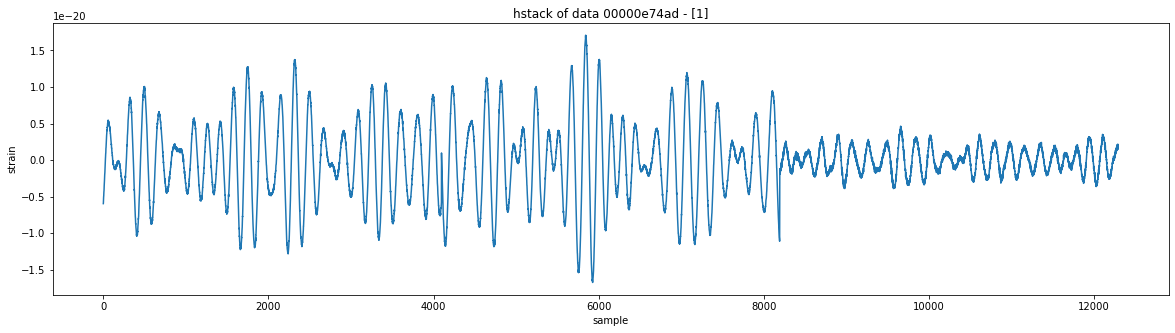

In [59]:
x.plot_hstack('00000e74ad',False)

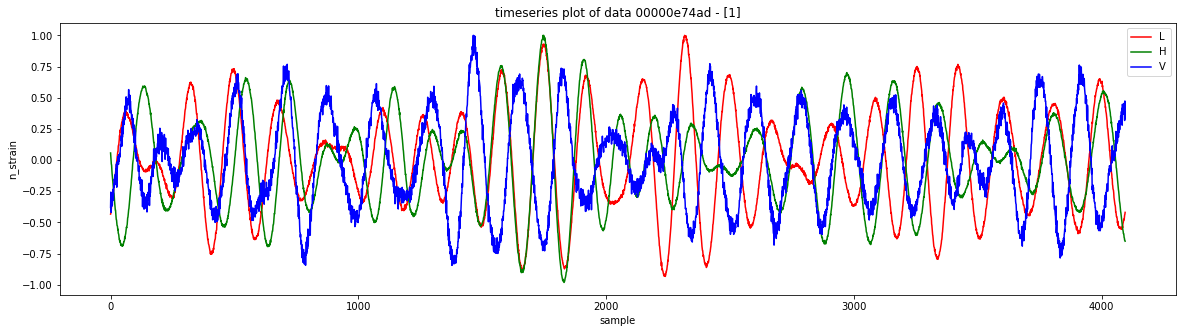

In [60]:
x.plot_parallel('00000e74ad',True)

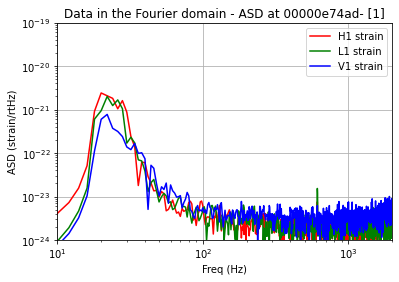

In [61]:
def ASD(t_id):
    NFFT = 1*s_freq
    fmin = 10
    fmax = 2000
    fs=s_freq*2
    strain=x.GW_np(t_id)
    Pxx_H1, freqs = mlb.psd(strain['a']['H'], Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlb.psd(strain['a']['L'], Fs = fs, NFFT = NFFT)
    Pxx_V1, freqs = mlb.psd(strain['a']['V'], Fs = fs, NFFT = NFFT)

    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)
    psd_V1 = interp1d(freqs, Pxx_V1)

    plt.figure()
    plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
    plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
    plt.loglog(freqs, np.sqrt(Pxx_V1),'b',label='V1 strain')
    plt.axis([fmin, fmax, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper right')
    plt.title(f'Data in the Fourier domain - ASD at '+t_id+'- ['+str(x.targets[x.targets['id'] == t_id].target.values[0])+']')
ASD('00000e74ad')

In [62]:
fn_H1 = 'H-H1_LOSC_4_V1-1126259446-32.hdf5'
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
# and then from L1
fn_L1 = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

# sampling rate:
fs = 4096
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]
len(strain_L1)

NameError: name 'rl' is not defined

In [63]:
len(x.GW_np('00000e74ad')['a']['L'])

4096

In [64]:
def whiten(s, interp_psd, dt):
    fq=np.fft.rfftfreq(len(s),dt)
    FT=np.fft.rfft(s)
    w_FT=FT/(np.sqrt(interp_psd(fq)/dt/2))
    w_FT=np.fft.irfft(w_FT,n=len(s))
    return w_FT
def iir_bandstops(fstops, fs, order=4):
    nyq = 0.5 * fs
    zd=np.array([])
    pd=np.array([])
    kd=1
    for fstopData in fstops:
        fstop=fstopData[0]
        df=fstopData[1]
        df2=fstopData[2]
        low=(fstop-df)/nyq
        high=(fstop+df)/nyq
        low2=(fstop-df2)/nyq
        high2=(fstop+df2)/nyq
        z,p,k=iirdesign([low,high], [low2,high2], gpass=1, gstop=6,ftype='ellip', output='zpk')
        zd=np.append(zd,z)
        pd=np.append(pd,p)                                     
    bPrelim,aPrelim=zpk2tf(zd, pd, 1)
    outFreq, outg0=freqz(bPrelim, aPrelim, 100/nyq)                              
    b,a=zpk2tf(zd,pd,k)
    return b,a

def get_filter_coefs(fs):
    coefs=[]
    lowcut=43
    highcut=260
    order=4
    nyq=0.5*fs
    low=lowcut / nyq
    high=highcut / nyq
    bb,ab=butter(order, [low, high], btype='band')
    coefs.append((bb,ab))
    notchesAbsolute=np.array([14.0,34.70, 35.30, 35.90, 36.70, 37.30, 40.95, 60.00, 120.00, 179.99, 304.99, 331.49, 510.02, 1009.99])
    for notchf in notchesAbsolute:                      
        bn,an=iir_bandstops(np.array([[notchf,1,0.1]]),fs,order=4)
        coefs.append((bn,an))   
    bn,an=iir_bandstops(np.array([[510,200,20]]),fs,order=4)
    coefs.append((bn, an))
    bn,an=iir_bandstops(np.array([[331.5,10,1]]),fs,order=4)
    coefs.append((bn,an))    
    return coefs

def filter_data(data_in,coefs):
    data=data_in.copy()
    for coef in coefs:
        b,a=coef
        data=filtfilt(b, a, data)
    return data

In [66]:
t=list(range(1,4097))
plt.figure()
plt.plot(t,a[0],'r',label='H1 strain')
plt.xlabel('time (s) since ')
plt.ylabel('strain')
plt.legend(loc='lower right')
plt.title('Advanced LIGO strain data near GW150914')

NameError: name 'a' is not defined

<Figure size 432x288 with 0 Axes>

In [74]:
x=[112,23,5,3]
x.append('axs')
x

[112, 23, 5, 3, 'axs']